<a href="https://colab.research.google.com/github/sudip2k17/aidoctextextractor/blob/main/OCRDocumentAndNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are few invoices from various retail shops and stored in datasources with jpg format.

OCRing process is going to be applied on those invoice images and extract content and then apply NLP techniques to take out context from unstructured texts.

Below steps are going to be followed.

Step 1: Extract words from images

Step 2: Labeling extracted text

Step 3: Classifying and Displaying results


In [9]:
!pip install easyocr

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Importing necessary packages

In [10]:
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import os
from bs4 import BeautifulSoup

import torch

from keras import layers
from keras.models import Model

from sklearn.model_selection import train_test_split

Check whether GPU is available, if yes run this program in GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
W,H = 320, 320

Setting up file paths

In [13]:
data_path = '/content/drive/MyDrive/dissertation/datasource/images'
box_path = '/content/drive/MyDrive/dissertation/datasource/boxes'
xml_path = '/content/drive/MyDrive/dissertation/datasource/annotations.xml'
east_path = '/content/drive/MyDrive/dissertation/datasource/east-model/frozen_east_text_detection.pb'

Default Label setting

In [14]:
determined_labels = {'shop': 0, 'item': 1, 'total': 2, 'date_time': 3, 'other': 4}

## Extracting Text



In [15]:
class ExtractingText:

    def __init__(self, solution: str, usingGPU: bool):

        self.gpu = usingGPU
        if 'Terr' or 'Easy' in solution:
            self.sol = solution
        else:
            print(f"Solution must be 'Tess' or Easy")


    def cleanup_text(self, text):
        # strip out non-ASCII text so we can draw the text on the image
        # using OpenCV
        return "".join([c if ord(c) < 128 else "" for c in text]).strip()

    """
    Tesseract
    """
    def Tesseract(self, dtset, min_length):
        if 'Tess' in self.sol:
            import pytesseract
            from PIL import Image

            char = []
            for idx in dtset:
                z = []
                image = Image.open(os.path.join(data_path, idx))
                data = pytesseract.image_to_data(image,
                                                 output_type=pytesseract.Output.DICT)

                for i in range(len(data['text'])):
                    text = data['text'][i]
                    text = self.cleanup_text(text)
                    if len(text) < min_length: continue
                    z.append([text])

                char.append([idx, z])
            return char

        else:
            print("Solution must be 'Tess'")

    """
    EASY OCR
    1. de_prob: probability 's threshold, default: 0.5
    2. languages: default: 'en', processing and extracting "English"
    """

    def get_results(self, ocr_results, de_prob):
        words = []
        for (bbox, text, prob) in ocr_results:
            if prob > de_prob and len(text)>2:
                text = self.cleanup_text(text)  # Assuming cleanup_text is defined elsewhere
                words.append([text])
        return words

    def EasyOCR(self, dtset, languages, de_prob=0.5):
        if 'Easy' in self.sol:
            from easyocr import Reader
            char_pos = []
            for idx in dtset:
                img_file = os.path.join(data_path, os.path.basename(idx))
                img = cv2.imread(img_file)
                reader = Reader([languages], gpu=self.gpu)
                results = reader.readtext(img)
                bboxes = self.get_results(results, de_prob)
                char_pos.append([idx, bboxes])
            return char_pos
        else:
            print("Solution must be 'Easy'")

Applying EasyOCR to invoice images

In [16]:
extract_text = ExtractingText('Easy', True)
word_position = extract_text.EasyOCR(sorted(os.listdir(data_path)), 'en', de_prob=0.2)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
# extract_text = ExtractingText('Tess', True)
# word_position = extract_text.Tesseract(sorted(os.listdir(data_path)), 5)

Preparing data with labeling

In [17]:
def get_data(annotation_file, ext_word, split_rate=0.2):

    dt_set = []

    with open(annotation_file, 'r') as f:
            data = f.read()
    Bs_data = BeautifulSoup(data, "xml")
    infors = Bs_data.find_all('image')

    for i, idx in enumerate(infors):
        k = []
        z = []
        org_dt = []
        name_file = idx.get('name')
        result = [inner_list[0] for inner_list in ext_word[i][1]]
        boxes = idx.find_all('box')

        for box in boxes:
            attribute_element = box.find('attribute', {'name': 'text'})
            text_content = attribute_element.text if attribute_element else None
            label = box.get('label')
            k.append((text_content, label))
            z.append([text_content, label])
            org_dt = z.copy()

        for x in result:
            match_found = False
            for i, j in k:
                if x in i:
                    z.append([x, j])
                    match_found = True
                    break  # Exit the inner loop once a match is found

            if not match_found:
                z.append([x, 'other'])


        dt_set.append([name_file, z + org_dt])

    train_dt, val_dt = train_test_split(dt_set, test_size=split_rate)

    return train_dt, val_dt

Setting up training and validation data set

In [18]:
train_ds, val_ds = get_data(xml_path, word_position, split_rate=0.4)

NLP - Classify Text with DistilBERT

In [19]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Setting up BATCH Size

In [20]:
BATCH_SIZE = 64

Utility function for NLP Data

In [21]:
def get_NLP_data(ds):

    X=[]; y = []
    for index in train_ds:
        for inf in index[1]:
            text = inf[0]
            label = determined_labels[inf[1]]
            X.append(text)
            y.append(label)

    return X, y

Setting up NLP data for training and validation

In [22]:
X_train, y_train = get_NLP_data(train_ds)
X_val, y_val = get_NLP_data(val_ds)

Applying NLP techniques

In [23]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

train_data = tokenizer(list(X_train), return_tensors="pt", padding=True, truncation=True)
valid_data = tokenizer(list(X_val), return_tensors="pt", padding=True, truncation=True)

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': torch.tensor(self.labels[idx])
        }

# Create dataset and dataloader
train_dataset = SentimentDataset(
    input_ids=train_data['input_ids'],
    attention_mask=train_data['attention_mask'],
    labels=y_train
)

val_dataset = SentimentDataset(
    input_ids=valid_data['input_ids'],
    attention_mask=valid_data['attention_mask'],
    labels=y_val
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Saving Best Model for NLP

In [24]:
class SaveBestModelCallback:
    def __init__(self, model, save_path):
        self.model = model
        self.save_path = save_path
        self.best_val_loss = float(0.65)

    def __call__(self, val_loss):
        if val_loss > self.best_val_loss:
            print(f"Validation loss improved ({self.best_val_loss:.6f} --> {val_loss:.6f}). Saving model...")
            torch.save(self.model.state_dict(), self.save_path)
            self.best_val_loss = val_loss
        else:
            print(f"Validation loss did not improve ({self.best_val_loss:.6f} --> {val_loss:.6f}).")

Applying DistilBert and measuring Loss Function

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
model = model.to(device)

save_callback = SaveBestModelCallback(model, '/content/drive/MyDrive/dissertation/models/best_model.pth')
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of DistilBertForSequenceClassification are not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']

Need to TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [28]:
from tqdm import tqdm

num_epochs = 12

for epoch in range(num_epochs):
    # Training loop
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(enumerate(train_dataloader, 1), total=len(train_dataloader))
    for step, batch in progress_bar:
        batch = {key: value.to(device) for key, value in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch['labels'])
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predictions = torch.argmax(outputs.logits, dim=1)
        correct = (predictions == batch['labels']).sum().item()
        total_correct += correct
        total_samples += len(batch['labels'])

        # Accumulate loss
        total_loss += loss.item()

        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}, Step {step}/{len(train_dataloader)}')
        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': correct / len(batch['labels'])})

    # Calculate training statistics for the epoch
    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = total_correct / total_samples

    # Validation loop
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_step, val_batch in enumerate(val_dataloader, 1):
            val_batch = {key: value.to(device) for key, value in val_batch.items()}
            val_outputs = model(**val_batch)
            val_loss = criterion(val_outputs.logits, val_batch['labels'])

            # Calculate accuracy
            val_predictions = torch.argmax(val_outputs.logits, dim=1)
            val_correct = (val_predictions == val_batch['labels']).sum().item()
            val_total_correct += val_correct
            val_total_samples += len(val_batch['labels'])

            # Accumulate loss
            val_total_loss += val_loss.item()

    # Calculate validation statistics for the epoch
    val_epoch_loss = val_total_loss / len(val_dataloader)
    val_epoch_accuracy = val_total_correct / val_total_samples

    save_callback(val_epoch_accuracy)

    # Print statistics for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}')

Epoch 1/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.30it/s, Loss=1.09, Accuracy=0.686]


Validation loss improved (0.650000 --> 0.720272). Saving model...
Epoch 1/12, Loss: 1.3173, Accuracy: 0.6908, Val Loss: 1.0169, Val Accuracy: 0.7203


Epoch 2/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.67it/s, Loss=0.632, Accuracy=0.863]


Validation loss improved (0.720272 --> 0.823330). Saving model...
Epoch 2/12, Loss: 0.8524, Accuracy: 0.7803, Val Loss: 0.6468, Val Accuracy: 0.8233


Epoch 3/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.32it/s, Loss=0.507, Accuracy=0.863]


Validation loss improved (0.823330 --> 0.861835). Saving model...
Epoch 3/12, Loss: 0.5994, Accuracy: 0.8313, Val Loss: 0.4836, Val Accuracy: 0.8618


Epoch 4/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.55it/s, Loss=0.312, Accuracy=0.941]


Validation loss improved (0.861835 --> 0.884485). Saving model...
Epoch 4/12, Loss: 0.4593, Accuracy: 0.8630, Val Loss: 0.3697, Val Accuracy: 0.8845


Epoch 5/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.67it/s, Loss=0.393, Accuracy=0.902]


Validation loss improved (0.884485 --> 0.916195). Saving model...
Epoch 5/12, Loss: 0.3685, Accuracy: 0.8890, Val Loss: 0.2836, Val Accuracy: 0.9162


Epoch 6/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.66it/s, Loss=0.349, Accuracy=0.902]


Validation loss improved (0.916195 --> 0.935447). Saving model...
Epoch 6/12, Loss: 0.2926, Accuracy: 0.9185, Val Loss: 0.2483, Val Accuracy: 0.9354


Epoch 7/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.57it/s, Loss=0.0911, Accuracy=1]


Validation loss improved (0.935447 --> 0.966025). Saving model...
Epoch 7/12, Loss: 0.2383, Accuracy: 0.9354, Val Loss: 0.1619, Val Accuracy: 0.9660


Epoch 8/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.46it/s, Loss=0.0762, Accuracy=0.98]


Validation loss improved (0.966025 --> 0.971687). Saving model...
Epoch 8/12, Loss: 0.1709, Accuracy: 0.9592, Val Loss: 0.1152, Val Accuracy: 0.9717


Epoch 9/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.58it/s, Loss=0.124, Accuracy=0.98]


Validation loss improved (0.971687 --> 0.976217). Saving model...
Epoch 9/12, Loss: 0.1384, Accuracy: 0.9660, Val Loss: 0.0855, Val Accuracy: 0.9762


Epoch 10/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.64it/s, Loss=0.0518, Accuracy=0.98]


Validation loss did not improve (0.976217 --> 0.968290).
Epoch 10/12, Loss: 0.1036, Accuracy: 0.9785, Val Loss: 0.1057, Val Accuracy: 0.9683


Epoch 11/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.53it/s, Loss=0.097, Accuracy=0.961]


Validation loss did not improve (0.976217 --> 0.972820).
Epoch 11/12, Loss: 0.0994, Accuracy: 0.9683, Val Loss: 0.0916, Val Accuracy: 0.9728


Epoch 12/12, Step 14/14: 100%|██████████| 14/14 [00:01<00:00,  7.38it/s, Loss=0.0285, Accuracy=1]


Validation loss improved (0.976217 --> 0.981880). Saving model...
Epoch 12/12, Loss: 0.0778, Accuracy: 0.9796, Val Loss: 0.0657, Val Accuracy: 0.9819


In [29]:
pred_values = []
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
try:
    model.load_state_dict(torch.load('/content/drive/MyDrive/dissertation/models/best_model.pth'))
except:
    model = model

for i in X_val:
    test_data = tokenizer(i, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**test_data)
        logits = outputs.logits

    # Convert logits to probabilities and get predicted label
    probabilities = torch.softmax(logits, dim=-1)
    predicted_label = torch.argmax(probabilities, dim=-1).item()

    pred_values.append(predicted_label)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Draw confusion matrix to see Actual and Predicted

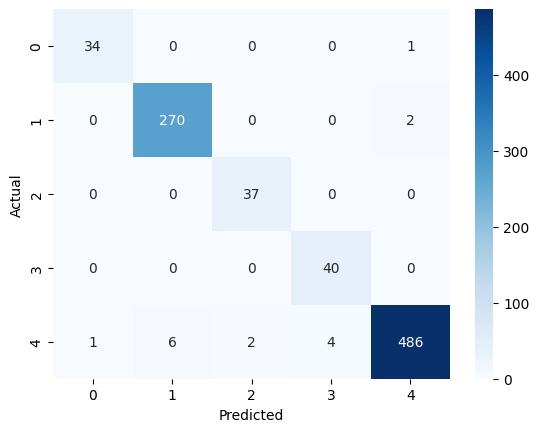

In [30]:
conf_matrix = confusion_matrix(y_val, pred_values)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Display

In [31]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 5)
model.load_state_dict(torch.load('/content/drive/MyDrive/dissertation/models/best_model.pth'))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

## EasyOCR Results

In [32]:
def easyOCR_results(image, title, min_len):
    from easyocr import Reader
    img = cv2.imread(image)
    reader = Reader(['en'], gpu=True)
    results = reader.readtext(img)

    for (bbox, text, prob) in results:
        if prob > int(min_len/100) and len(text) > min_len:
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))

            text = extract_text.cleanup_text(text)
            tknz = tokenizer(text, return_tensors="pt")

            with torch.no_grad():
                outputs = model(**tknz)
                logits = outputs.logits

            probabilities = torch.softmax(logits, dim=-1)
            predicted_label = torch.argmax(probabilities, dim=-1).item()

            for label, value in determined_labels.items():
                 if value == predicted_label:
                        text = label

            if 'shop' in text:
                cv2.rectangle(img, tl, br, (255, 0, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

            elif 'item' in text:
                cv2.rectangle(img, tl, br, (0, 175, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 175, 0), 2)
            elif 'total' in text:
                cv2.rectangle(img, tl, br, (0, 0, 255), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

            elif 'other' in text:
                cv2.rectangle(img, tl, br, (0, 0, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

            else:
                cv2.rectangle(img, tl, br, (255, 175, 0), 2)
                cv2.putText(img, text, (tl[0], tl[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 175, 0), 2)

    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [33]:
def Tess_results(image, title, min_len):
    import pytesseract
    img = cv2.imread(image)
    data = pytesseract.image_to_data(image,
                                     output_type=pytesseract.Output.DICT)

    for i in range(len(data['text'])):
        text = data['text'][i]
        text = extract_text.cleanup_text(text)
        if len(text) < min_len: continue

        tknz = tokenizer(text, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**tknz)
            logits = outputs.logits

        probabilities = torch.softmax(logits, dim=-1)
        predicted_label = torch.argmax(probabilities, dim=-1).item()

        for label, value in determined_labels.items():
             if value == predicted_label:
                    text = label

        x, y, width, height = int(data['left'][i]), int(data['top'][i]), int(data['width'][i]), int(data['height'][i])

        if 'shop' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (255, 0, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


        elif 'item' in text:
                cv2.rectangle(img, (x, y), (x + width, y + height), (0, 175, 0), 2)
                cv2.putText(img, text, (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 175, 0), 2)
        elif 'total' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (0, 0, 255), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        elif 'other' in text:
            cv2.rectangle(img, (x, y), (x + width, y + height), (0, 0, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

        else:
            cv2.rectangle(img, (x, y), (x + width, y + height), (255, 175, 0), 2)
            cv2.putText(img, text, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 175, 0), 2)

    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [34]:
def display_results(test_dt, method='Easy', min_len=5):
    file_val = [inner_list[0] for inner_list in test_dt]
    if method == 'Easy':
        for idx in file_val:
            img_file = os.path.join(data_path, os.path.basename(idx))
            easyOCR_results(img_file, idx, min_len)

    elif method == 'Tess':
        for idx in file_val:
            img_file = os.path.join(data_path, os.path.basename(idx))
            Tess_results(img_file, idx, min_len)

    else:
        print("Method must be 'Tess' or 'Easy'")

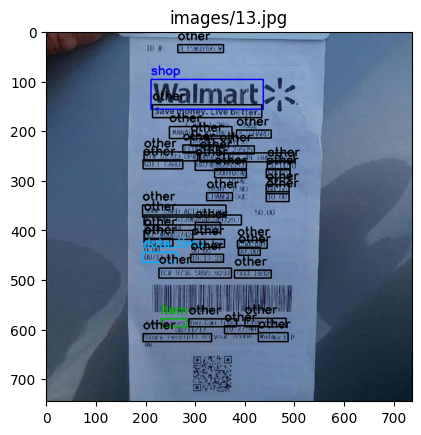

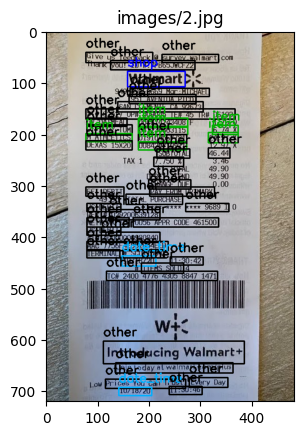

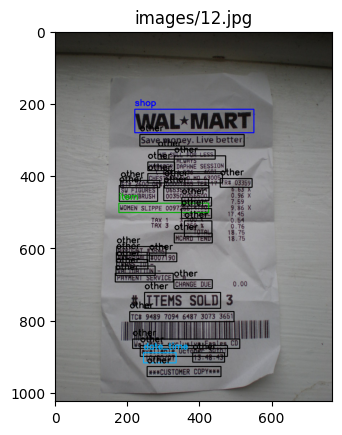

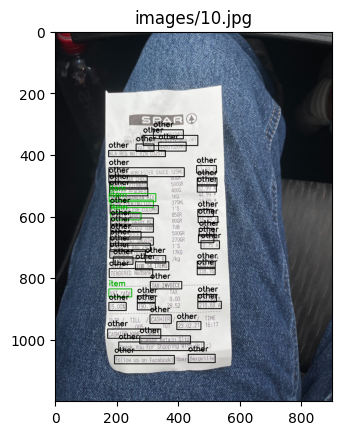

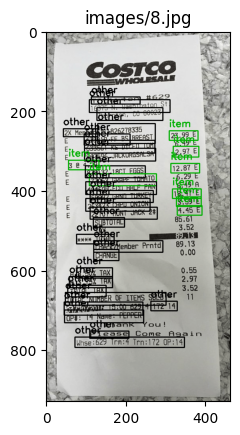

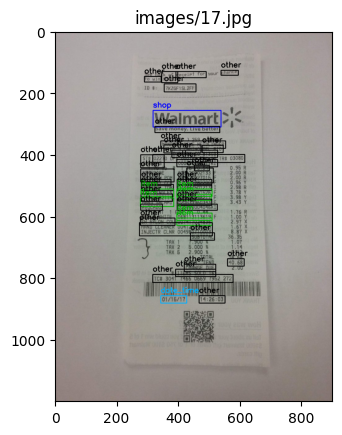

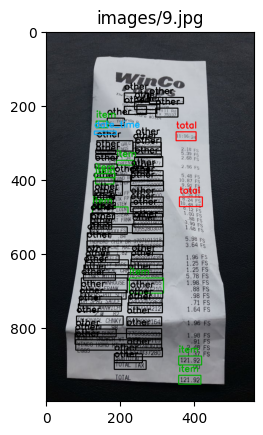

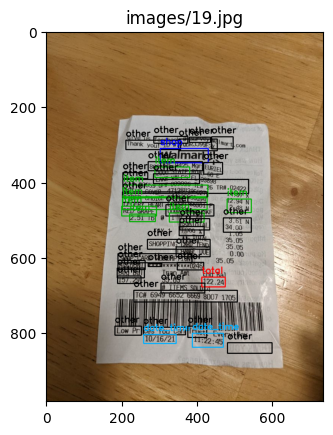

In [35]:
display_results(val_ds, method='Easy', min_len=5)

## Text Detection

In [36]:
!pip install --upgrade imutils

In [37]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2

In [38]:
layerNames = ["feature_fusion/Conv_7/Sigmoid",
              "feature_fusion/concat_3"]

In [39]:
def model_resutls(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue
            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append([startX, startY, endX, endY])
            confidences.append(scoresData[x])

    # NMS
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    return boxes

In [46]:
def detectText(dtset, model_path):

    bboxes = []

    # Check if model file exists
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at {model_path}")
        return bboxes

    for idx in dtset:

        # Read/ resize image
        image_file = os.path.join(data_path, os.path.basename(idx[0]))
        img = cv2.imread(image_file)
        img = cv2.resize(img, (W, H))

        try:
          # Load model
          net = cv2.dnn.readNet(model_path)
        except Exception as e:
            print(f"Error loading model: {e}")
            return bboxes

        # Detect
        blob = cv2.dnn.blobFromImage(img, 1.0, (W, H),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
        net.setInput(blob)
        (scores, geometry) = net.forward(layerNames)

        # Get results
        boxes = model_resutls(scores, geometry)

        bboxes.append(boxes)

    return bboxes

In [47]:
def draw_bbox(dtset):

    bb = detectText(val_ds, east_path)

    for i, idx in enumerate(dtset):
        file = os.path.join(data_path, os.path.basename(idx[0]))
        img = cv2.imread(file)
        img = cv2.resize(img, (W,H))

        for k in bb[i]:
            cv2.rectangle(img, (k[0], k[1]), (k[2], k[3]), (0,0,0,0))

        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()  # Show each image separately

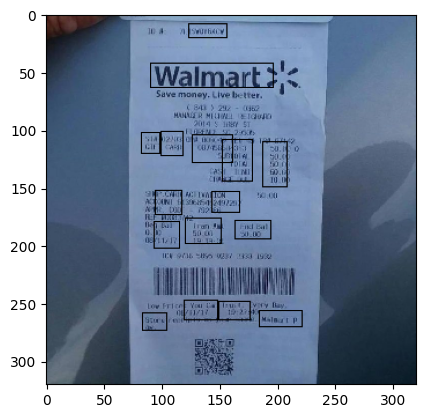

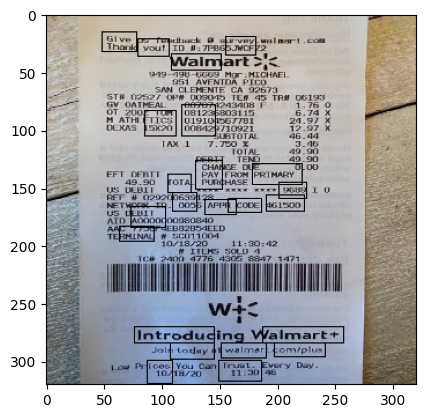

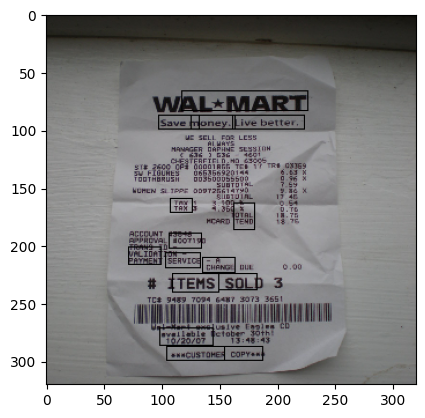

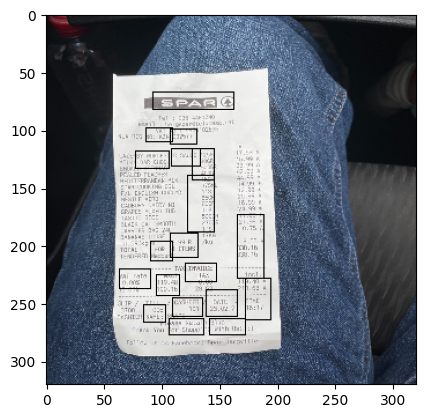

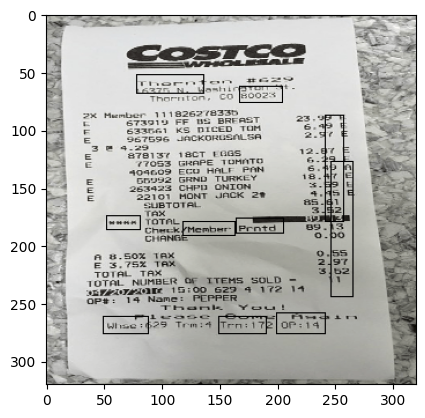

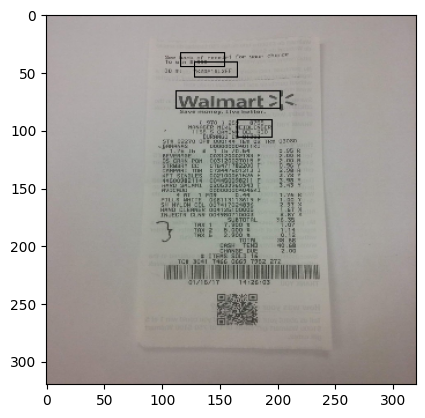

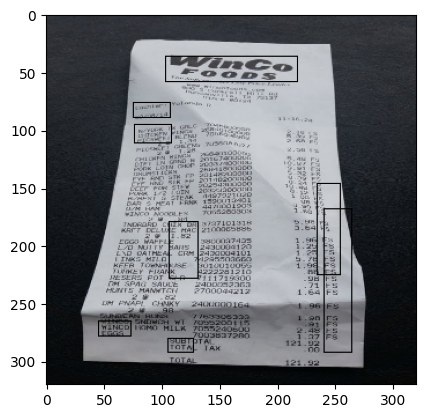

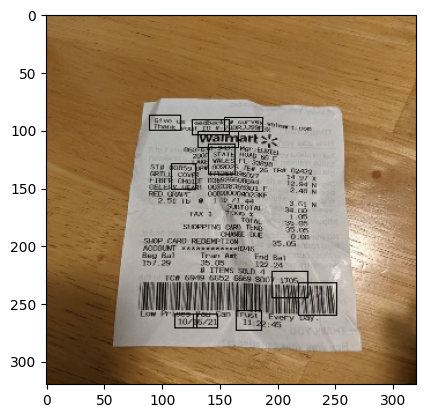

In [48]:
draw_bbox(val_ds)

## Donut Model


In [49]:
pip install -q transformers datasets sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests